In [1]:
%%time

#Modded from qutip to allow parallelism
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator

def floquet_modes_mod(H, T, args=None, parallel=False, sort=False, U=None):
    """
    Calculate the initial Floquet modes Phi_alpha(0) for a driven system with
    period T.

    Returns a list of :class:`qutip.qobj` instances representing the Floquet
    modes and a list of corresponding quasienergies, sorted by increasing
    quasienergy in the interval [-pi/T, pi/T]. The optional parameter `sort`
    decides if the output is to be sorted in increasing quasienergies or not.

    Parameters
    ----------

    H : :class:`qutip.qobj`
        system Hamiltonian, time-dependent with period `T`

    args : dictionary
        dictionary with variables required to evaluate H

    T : float
        The period of the time-dependence of the hamiltonian. The default value
        'None' indicates that the 'tlist' spans a single period of the driving.

    U : :class:`qutip.qobj`
        The propagator for the time-dependent Hamiltonian with period `T`.
        If U is `None` (default), it will be calculated from the Hamiltonian
        `H` using :func:`qutip.propagator.propagator`.

    Returns
    -------

    output : list of kets, list of quasi energies

        Two lists: the Floquet modes as kets and the quasi energies.

    """
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        # get the unitary propagator
        U = propagator(H, T, [], args, parallel=parallel, progressbar=True, options=options)
    
    # find the eigenstates for the propagator
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)

    # make sure that the phase is in the interval [-pi, pi], so that
    # the quasi energy is in the interval [-pi/T, pi/T] where T is the
    # period of the driving.  eargs += (eargs <= -2*pi) * (2*pi) +
    # (eargs > 0) * (-2*pi)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    # sort by the quasi energy
    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    # prepare a list of kets for the floquet states
    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

CPU times: user 769 ms, sys: 123 ms, total: 892 ms
Wall time: 1.73 s


/usr/local/anaconda3/anaconda3/envs/hpc/lib/python3.11/site-packages/qutip/configrc.py:294: UserWarning: Invalid qutip config variable in qutiprc: num_cpus
  warnings.warn("Invalid qutip config variable in qutiprc: "


In [2]:
import numpy as np
from qutip import mesolve, basis, jmat

def drive(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * np.cos(w*t) + h0

def get_hamiltonians(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                      # kacNorm
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1

def floq_evolv(args):
    N = args['N']
    T = 2 * np.pi/args['omega']
    opts = args['opts']
    H0, H1 = get_hamiltonians(N)
    H = [H0,[H1,drive]]
    f_states, _ = floquet_modes_mod(H, T, args=args, parallel=True)
    return f_states


print("Definitions complete!")

Definitions complete!


In [8]:
%%time
from qutip import Qobj, jmat, Options
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import h5py

N = 100
nprocs = 12
w_in, w_fin = 0.1, 40.0
h_in, h_fin = 1.0, 40.0
nsteps = 4

h0 = np.sqrt(3)
sx = jmat(N,"x")
en, st = sx.eigenstates()

def get_ipravg(w,h):
    opts = Options(nsteps=1e8, num_cpus=nprocs, openmp_threads=1)
    params = {'h0':h0, 'h':h, 'omega':w, 'N':N, 'opts':opts}
    f_states = floq_evolv(params)
    ipr_avg = np.average([np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states])
    return ipr_avg

omegas = np.linspace(w_in, w_fin, nsteps)
ampls = np.linspace(h_in, h_fin, nsteps)
    
gr = np.meshgrid(omegas, ampls)
res = np.array(gr).reshape(2, -1).T

iprz = np.array([[w,h,get_ipravg(w,h)] for w,h in res])

with h5py.File("ipr_avg_wh.hdf5", "w") as f:
    ipr_avg_dataset = f.create_dataset("ipr_avg", data=iprz)
    ipr_avg_dataset.attrs['nspins'] = N
    ipr_avg_dataset.attrs['h0'] = h0

print("Done!")

Done!
CPU times: user 3min 27s, sys: 4min 13s, total: 7min 41s
Wall time: 9min 56s


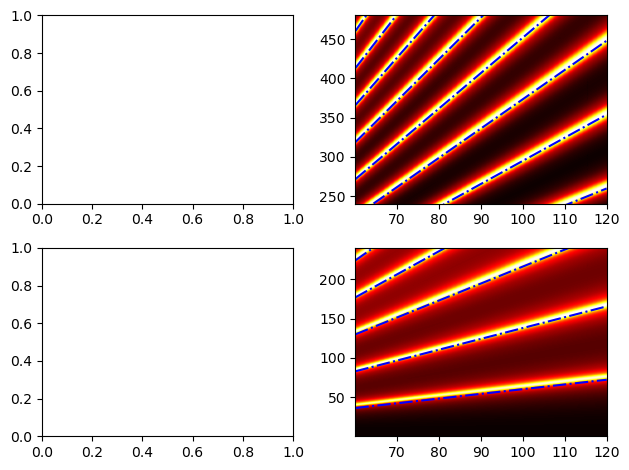

CPU times: user 485 ms, sys: 4.36 ms, total: 490 ms
Wall time: 495 ms


In [40]:
%%time
import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.special import jn_zeros

fig, axs = plt.subplots(2, 2, tight_layout=True)

with h5py.File("../wh_space/ipr_avg_lr.hdf5", "r") as f:
    ax_lr = axs[1,1]
    iprz_lr = np.array(f["ipr_avg"])
    X_lr,Y_lr,Z_lr = iprz_lr[:,0], iprz_lr[:,1], iprz_lr[:,2]
    w_in, w_fin = np.amin(X_lr),np.amax(X_lr)
    h_in, h_fin = np.amin(Y_lr),np.amax(Y_lr)

    nsteps_fine = X_lr.shape[0]
    omegas_fine = np.linspace(w_in, w_fin, nsteps_fine)
    ampls_fine = np.linspace(h_in, h_fin, nsteps_fine)

    slopes = jn_zeros(0,10)/4

    for slope in slopes:
        ax_lr.plot(omegas_fine, omegas_fine*slope,'b-.')
    
    N = int(len(Z_lr)**.5)
    z = Z_lr.reshape(N, N)
    z_lr = z[::-1]
    ax_lr.imshow(z_lr, extent=(w_in, w_fin, h_in, h_fin),cmap='hot', aspect = 'auto')

with h5py.File("../wh_space/ipr_avg_ur.hdf5", "r") as f:
    ax_ur = axs[0,1]
    iprz_ur = np.array(f["ipr_avg"])
    X_ur,Y_ur,Z_ur = iprz_ur[:,0], iprz_ur[:,1], iprz_ur[:,2]
    w_in, w_fin = np.amin(X_ur),np.amax(X_ur)
    h_in, h_fin = np.amin(Y_ur),np.amax(Y_ur)

    nsteps_fine = X_ur.shape[0]
    omegas_fine = np.linspace(w_in, w_fin, nsteps_fine)
    ampls_fine = np.linspace(h_in, h_fin, nsteps_fine)

    slopes = jn_zeros(0,10)/4

    for slope in slopes:
        ax_ur.plot(omegas_fine, omegas_fine*slope,'b-.')
    
    N = int(len(Z_ur)**.5)
    z = Z_ur.reshape(N, N)
    z_ur = z[::-1]
    ax_ur.imshow(z_ur, extent=(w_in, w_fin, h_in, h_fin),cmap='hot', aspect = 'auto')




#plt.colorbar()
plt.show()

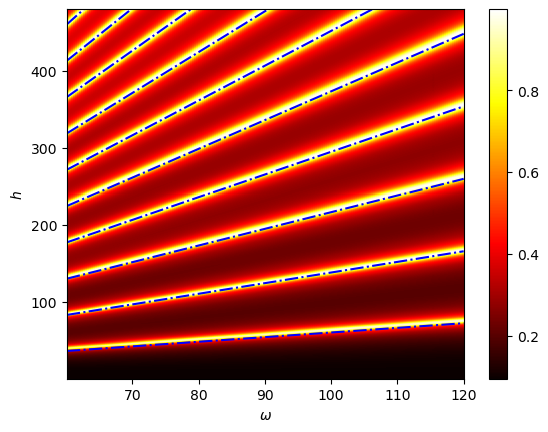

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.special import jn_zeros


X = X_lr
Y = np.concatenate((Y_lr, Y_ur))
Z = np.concatenate((z_ur.T, z_lr.T), axis=1)

w_in, w_fin = np.amin(X),np.amax(X)
h_in, h_fin = np.amin(Y),np.amax(Y)
nsteps_fine = X.shape[0]
omegas_fine = np.linspace(w_in, w_fin, nsteps_fine)
ampls_fine = np.linspace(h_in, h_fin, nsteps_fine)
slopes = jn_zeros(0,10)/4

for slope in slopes:
    plt.plot(omegas_fine, omegas_fine*slope,'b-.')
        
plt.imshow(Z.T,cmap='hot',extent=(w_in, w_fin, h_in, h_fin), aspect = 'auto')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$h$')

plt.colorbar()
plt.show()